In [ ]:
import numpy as np
from scipy.optimize import line_search # For a robust line search

# --- 1. Define Objective Function and Gradient ---

def rosenbrock(x):
    """
    Rosenbrock function: f(x, y) = (1 - x)^2 + 100 * (y - x^2)^2
    Minimum at (1, 1) with f(1,1) = 0.
    """
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_gradient(x):
    """
    Gradient of the Rosenbrock function.
    """
    dfdx = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
    dfdy = 200 * (x[1] - x[0]**2)
    return np.array([dfdx, dfdy])

# --- 2. L-BFGS Two-Loop Recursion (Algorithm 7.4) ---

def lbfgs_two_loop_recursion(grad_k, s_history, y_history, H0_scaling_factor):
    """
    Computes H_k @ grad_k efficiently using the two-loop recursion.

    Args:
        grad_k (np.array): Current gradient vector (nabla_f_k).
        s_history (list): List of s_i vectors (x_{i+1} - x_i) for i in [k-m, ..., k-1].
        y_history (list): List of y_i vectors (nabla_f_{i+1} - nabla_f_i) for i in [k-m, ..., k-1].
        H0_scaling_factor (float): The gamma_k scaling factor for the initial H_k^0 = gamma_k * I.

    Returns:
        np.array: The computed product H_k @ grad_k, which is -p_k (negative search direction).
    """
    q = np.copy(grad_k)
    m = len(s_history) # Actual number of pairs currently stored (<= max_m)
    
    # Store alpha_i values for the second loop
    alphas = [0.0] * m

    # First loop (forward pass)
    for i in range(m - 1, -1, -1): # Iterate from m-1 down to 0 (most recent to oldest)
        s_i = s_history[i]
        y_i = y_history[i]
        
        # rho_i = 1 / (y_i.T @ s_i) -- already handled by curvature check, should be > 0
        rho_i = 1.0 / np.dot(y_i, s_i)
        
        alphas[i] = rho_i * np.dot(s_i, q)
        q = q - alphas[i] * y_i

    # Apply H_k^0 (scaled identity matrix)
    # r = H_k^0 @ q = gamma_k * I @ q = gamma_k * q
    r = H0_scaling_factor * q

    # Second loop (backward pass)
    for i in range(m): # Iterate from 0 up to m-1 (oldest to most recent)
        s_i = s_history[i]
        y_i = y_history[i]
        
        rho_i = 1.0 / np.dot(y_i, s_i) # Recalculate rho_i
        
        beta = rho_i * np.dot(y_i, r)
        r = r + s_i * (alphas[i] - beta)

    return r

# --- 3. L-BFGS Main Algorithm (Algorithm 7.5) ---

def lbfgs_optimizer(x0, f, grad_func, m=10, epsilon=1e-6, max_iterations=1000):
    """
    L-BFGS optimization algorithm.

    Args:
        x0 (np.array): Initial guess for the parameters.
        f (callable): The objective function f(x) to minimize.
        grad_func (callable): The gradient function nabla_f(x).
        m (int): The number of history pairs (s_i, y_i) to store (memory limit).
        epsilon (float): Convergence tolerance for the gradient norm.
        max_iterations (int): Maximum number of iterations.

    Returns:
        tuple: (optimal_x, optimal_fval, num_iterations)
    """
    x_k = np.array(x0, dtype=float)
    n = len(x_k)

    # History lists for s_i and y_i pairs
    s_history = []
    y_history = []

    k = 0
    nabla_f_k = grad_func(x_k)

    print(f"Initial x: {x_k}, f(x): {f(x_k):.6f}, ||grad||: {np.linalg.norm(nabla_f_k):.6f}")

    while np.linalg.norm(nabla_f_k) > epsilon and k < max_iterations:
        # 1. Choose H_k^0 (scaling factor gamma_k)
        # Use formula (7.20) for gamma_k
        if k == 0:
            # For the very first iteration, gamma_k is often 1, or can be skipped
            # as s_history/y_history are empty.
            # A common approach is to just use I for the first step, so p_k = -grad_k
            # Or, if you want a scaling, you need previous s, y which don't exist yet.
            H0_scaling_factor = 1.0 
        else:
            # Use the most recent s and y for scaling (s_{k-1}, y_{k-1})
            s_prev = s_history[-1] 
            y_prev = y_history[-1]
            H0_scaling_factor = np.dot(s_prev, y_prev) / np.dot(y_prev, y_prev)
            # Handle potential division by zero if y_prev is zero (shouldn't happen with good line search)
            if np.dot(y_prev, y_prev) == 0:
                H0_scaling_factor = 1.0 # Fallback
            

        # 2. Compute search direction p_k using two-loop recursion
        # The two-loop recursion calculates H_k @ grad_k, so p_k = -(H_k @ grad_k)
        Hk_grad_k = lbfgs_two_loop_recursion(nabla_f_k, s_history, y_history, H0_scaling_factor)
        p_k = -Hk_grad_k

        # 3. Line search to find alpha_k
        alpha_star, fc, gc, new_fval, new_grad, new_a = line_search(
            f, grad_func, x_k, p_k, gfk=nabla_f_k
        )

        if alpha_star is None:
            print(f"Line search failed at iteration {k}. Terminating.")
            break

        # 4. Update x_{k+1}
        x_k_plus_1 = x_k + alpha_star * p_k

        # 5. Compute and store s_k and y_k
        s_k = x_k_plus_1 - x_k
        nabla_f_k_plus_1 = new_grad # Use the gradient from line search if available
        y_k = nabla_f_k_plus_1 - nabla_f_k

        # --- Crucial: Curvature Condition Check ---
        # (Implicitly handled by line_search satisfying strong Wolfe,
        # but good to explicitly check or at least ensure s_k.T @ y_k > 0 for rho_k)
        s_k_dot_y_k = np.dot(s_k, y_k)
        if s_k_dot_y_k <= 1e-8: # Using a small tolerance instead of exact zero
            print(f"Curvature condition violated or near zero at iteration {k}: s_k.T @ y_k = {s_k_dot_y_k:.2e}. Skipping update for history.")
            # In some implementations, they might discard this s_k, y_k pair
            # or reset the history. For simplicity here, we'll just not add it
            # if it's problematic, and rely on the existing history.
            # However, for a *correct* L-BFGS, if the strong Wolfe conditions are met,
            # this condition *should* hold. If it doesn't, it indicates an issue
            # with the line search or a highly pathological function.
            # For this simple implementation, let's break if it's severely violated
            # as it implies issues that the simple setup won't recover from easily.
            if s_k_dot_y_k <= 0: # Strict violation
                break 
            
        else: # If curvature condition is met, add to history
            if len(s_history) >= m:
                # Discard the oldest pair if memory limit is reached
                s_history.pop(0)
                y_history.pop(0)
            s_history.append(s_k)
            y_history.append(y_k)

        # Update for next iteration
        x_k = x_k_plus_1
        nabla_f_k = nabla_f_k_plus_1
        k += 1
        
        # Optional: Print progress
        if k % 50 == 0 or k == 1:
             print(f"Iteration {k}: f(x) = {f(x_k):.6f}, ||grad|| = {np.linalg.norm(nabla_f_k):.6f}")

    print(f"\nOptimization finished after {k} iterations.")
    print(f"Final x: {x_k}")
    print(f"Final f(x): {f(x_k)}")
    print(f"Final ||grad||: {np.linalg.norm(nabla_f_k)}")
    
    return x_k, f(x_k), k

In [ ]:
initial_guess = np.array([-1.2, 1.0]) # Standard starting point for Rosenbrock

print("--- Running Custom L-BFGS ---")
optimal_x_custom, optimal_f_custom, iterations_custom = lbfgs_optimizer(
    initial_guess, rosenbrock, rosenbrock_gradient, m=10, epsilon=1e-6, max_iterations=1000
)

print("\n--- Verifying with SciPy's L-BFGS-B (Limited-memory BFGS with bounds) ---")
from scipy.optimize import minimize
res_scipy = minimize(rosenbrock, initial_guess, method='L-BFGS-B', jac=rosenbrock_gradient)
print(f"SciPy Optimal x: {res_scipy.x}")
print(f"SciPy Optimal f(x): {res_scipy.fun}")
print(f"SciPy Iterations: {res_scipy.nit}")

# Another example with a different function (e.g., a simple quadratic)
def quadratic(x):
    return x[0]**2 + 2*x[1]**2 + 3*x[2]**2

def quadratic_gradient(x):
    return np.array([2*x[0], 4*x[1], 6*x[2]])

print("\n--- Running Custom L-BFGS on a Quadratic Function ---")
initial_guess_quad = np.array([5.0, 4.0, 3.0])
optimal_x_quad, optimal_f_quad, iterations_quad = lbfgs_optimizer(
    initial_guess_quad, quadratic, quadratic_gradient, m=5, epsilon=1e-6, max_iterations=500
)

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
def f(x):
    '''
    FUNCTION TO BE OPTIMISED
    '''
    d = len(x)
    return sum(100*(x[i+1]-x[i]**2)**2 + (x[i]-1)**2 for i in range(d-1))

#Calculate the gradient of this function:

def grad(f, x):
    d = len(x)
    nabla = np.zeros(d)
    for i in range(d):
        if i == 0:
            nabla[i] = -400 * x[0] * (x[1] - x[0]**2) + 2 * (x[0] - 1)
        elif i == d - 1:
            nabla[i] = 200 * (x[d - 1] - x[d - 2]**2)
        else:
            nabla[i] = (-400 * x[i] * (x[i+1] - x[i]**2) +
                       2 * (x[i] - 1) +
                       200 * (x[i] - x[i-1]**2))
    return nabla

def grad_2(f, x): 
    '''
    CENTRAL FINITE DIFFERENCE CALCULATION
    '''
    h = np.cbrt(np.finfo(float).eps)
    d = len(x)
    nabla = np.zeros(d)
    for i in range(d):
        x_for = np.copy(x)
        x_back = np.copy(x)
        x_for[i] += h
        x_back[i] -= h
        nabla[i] = (f(x_for) - f(x_back))/(2*h) 
    return nabla 

def line_search(f, x, p, nabla):
    '''
    BACKTRACK LINE SEARCH WITH WOLFE CONDITIONS
    '''
    a = 1
    c1 = 1e-4 
    c2 = 0.9 
    fx = f(x)
    x_new = x + a * p
    nabla_new = grad(f, x_new)
    while f(x_new) >= fx + (c1*a*nabla.T@p) or nabla_new.T@p <= c2*nabla.T@p : 
        a = a * 0.9
        x_new = x + a * p 
        nabla_new = grad(f, x_new)
    return a

def two_loop_recursion(grad, s_stored, y_stored, m):
    '''
    Two-loop recursion to compute H_k @ gradient.
    '''
    # Initialize variables
    q = grad
    length = len(q)
    a = np.zeros(m)

    # Compute rho_i = 1 / (y_i^T s_i)
    rho = np.array([1/np.dot(y_stored[i, :], s_stored[i, :]) for i in range(m)])

    # 1. First loop
    for i in range(m):
        ## Compute alpha_i
        a[m - 1 - i] = rho[m - 1 - i] * np.dot(s_stored[m - 1 - i, :], q)
        ## Update q
        q = q - a[m - 1 - i]*y_stored[m - 1 - i, :]

    # 2. Apply initial Hessian approximation H_k^0 
    ## H_k^0= (s_{k-1}^T y_{k-1})/(y_{k-1}^T y_{k-1}) * I
    H_k0 = (np.dot(s_stored[m - 1], y_stored[m - 1])/np.dot(y_stored[m - 1], y_stored[m - 1]))
    ## Compute r = H_k^0 * q
    r = H_k0 * q
    
    # 3. Second loop
    for i in range(m):
        # Compute beta_i
        beta = rho[i] * np.dot(y_stored[i, :], r)
        # Update r
        r = r + (a[i] - beta) * s_stored[i]
    return r

def l_bfgs(f, x_init, max_it, m, eps=1e-5):
    # Initialization
    d = len(x_init)
    nabla = grad(f, x_init)
    x = x_init[:]
    x_store = np.array([x_init])

    # Store the {y_i, s_i}
    y_stored = []
    s_stored = []

    # Initialize search direction
    p = - nabla

    # Compute step length alpha using line search
    alpha = line_search(f, x, p, nabla)

    # Store initial s_0 and y_0
    s_stored.append(alpha * p)

    grad_old = nabla[:]
    x = x + alpha * p
    nabla = grad(f, x)
    y_stored.append(nabla - grad_old)

    # Initialize iteration counter and memory counter
    m_ = 1
    it = 1
    x_store = np.append(x_store, [x], axis = 0)

    # Check if gradient norm is larger than tolerance epsilon
    while np.linalg.norm(nabla) > eps: 
        # Check maximum iterations
        if it > max_it: 
            break

        # Loop over m iterations
        if 0 < it and it < m:
            # Compute search direction using two-loop recursion
            p = - two_loop_recursion(nabla, np.array(s_stored), np.array(y_stored), m_)
            # Compute step length alpha using line search
            alpha = line_search(f, x, p, nabla)
            # Store the s_k+1 and y_k+1
            s_stored.append(alpha * p)
            grad_old = nabla[:]
            x = x + alpha * p
            nabla = grad(f, x)
            y_stored.append(nabla - grad_old)
            # Increment memory counter
            m_ = m_ + 1
            it = it + 1
            x_store = np.append(x_store, [x], axis = 0)
            
        # After m iterations, maintain a fixed memory of size m
        else:
            # Compute search direction using two-loop recursion
            p = - two_loop_recursion(nabla, np.array(s_stored), np.array(y_stored), m)
            # Compute step length alpha using line search
            alpha = line_search(f, x, p, nabla)

            # Append the s_k+1
            s_stored.append(alpha * p)

            # Discard the s_k-m
            s_stored.pop(0)
            grad_old = nabla[:]
            x = x + alpha * p
            nabla = grad(f, x)

            # Append the y_k+1
            y_stored.append(nabla - grad_old)

            # Discard the y_k-m
            y_stored.pop(0)
            
            # Increment iteration counter
            it = it + 1
            x_store = np.append(x_store, [x], axis = 0)
    
    return x, x_store

# Implement L-BFGS
# x0 = [-1.5, 2.5]
# x0 = np.zeros(2)
# x0 = np.random.uniform(low=-2, high=2, size=2)
# x0 = np.random.randn(2) * 0.1
# x0 = np.random.uniform(low=-1.5, high=1.5, size=2)
# x0 = np.array([-1.2, 1.0] * (2 // 2))

x0 = np.array([-1.2, 1.0])
m = 10
max_it = 100
x_optimal, xstore = l_bfgs(f, x0, max_it, m, eps=1e-5)
print("Optimal solution:", x_optimal, "after ", len(xstore), "steps")

Optimal solution: [1.         1.00000001] after  25 steps


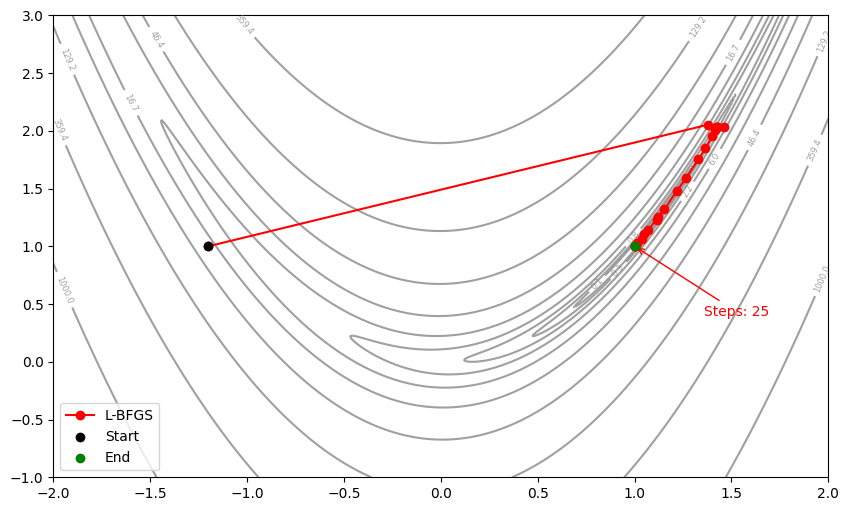

In [4]:
from scipy.optimize import rosen
# --- Plot contour and path ---
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosen(np.array([X, Y]))

plt.figure(figsize=(10, 6))
# Contour plot of Rosenbrock (grey contour lines)
cp = plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 10), colors='grey', alpha=0.75)
plt.clabel(cp, inline=True, fontsize=6)

# Optimization path
x_points = xstore[:, 0]
y_points = xstore[:, 1]
plt.plot(x_points, y_points, 'o-', color='red', label='L-BFGS')
plt.scatter(x_points[0], y_points[0], color='black', label='Start', zorder=5)
plt.scatter(x_points[-1], y_points[-1], color='green', label='End', zorder=5)

num_steps = len(xstore)
plt.annotate(f'Steps: {num_steps}', xy=(x_points[-1], y_points[-1]), xytext=(50, -50),
             textcoords='offset points', fontsize=10, color='r',
             arrowprops=dict(arrowstyle='->', color='r'))

# plt.title('L-BFGS Optimization Path on Rosenbrock Function')
# plt.xlabel('x')
# plt.ylabel('y')
plt.legend(loc='lower left')
# plt.grid(True)
plt.show()

In [ ]:
# save xstore as file
np.save("l_bfgs_steps.npy", xstore)

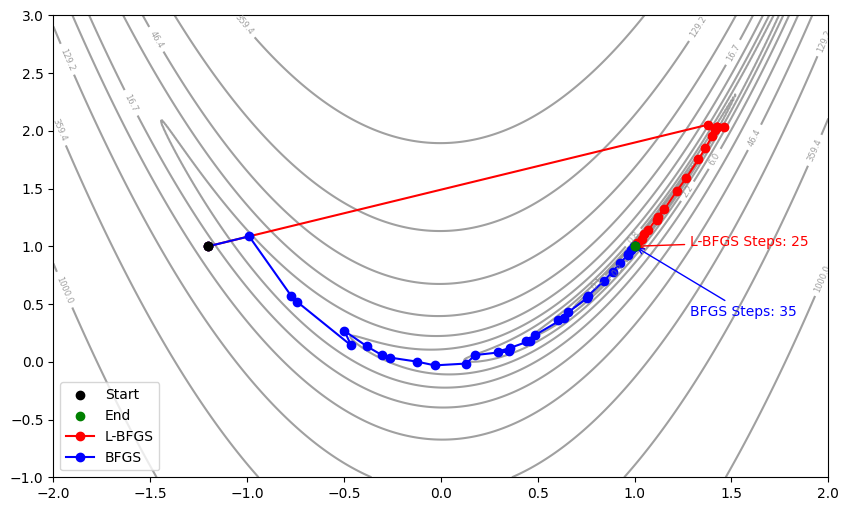

In [11]:
bfgs_steps = np.load("bfgs_steps.npy")
l_bfgs_steps = np.load("l_bfgs_steps.npy")

from scipy.optimize import rosen
# --- Plot contour and path ---
x_vals = np.linspace(-2, 2, 400)
y_vals = np.linspace(-1, 3, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosen(np.array([X, Y]))

plt.figure(figsize=(10, 6))
# Contour plot of Rosenbrock (grey contour lines)
cp = plt.contour(X, Y, Z, levels=np.logspace(-1, 3, 10), colors='grey', alpha=0.75)
plt.clabel(cp, inline=True, fontsize=6)

# Optimization path of L-BFGS
x_points = l_bfgs_steps[:, 0]
y_points = l_bfgs_steps[:, 1]
plt.scatter(x_points[0], y_points[0], color='black', label='Start', zorder=5)
plt.scatter(x_points[-1], y_points[-1], color='green', label='End', zorder=5)
plt.plot(x_points, y_points, 'o-', color='red', label='L-BFGS')

lbfgs_num_steps = len(l_bfgs_steps)
plt.annotate(f'L-BFGS Steps: {lbfgs_num_steps}', xy=(x_points[-1], y_points[-1]), xytext=(40, 0),
             textcoords='offset points', fontsize=10, color='r',
             arrowprops=dict(arrowstyle='->', color='r'))

# Optimization path of BFGS
x_points = bfgs_steps[:, 0]
y_points = bfgs_steps[:, 1]
plt.plot(x_points, y_points, 'o-', color='blue', label='BFGS')
plt.scatter(x_points[0], y_points[0], color='black', zorder=5)
plt.scatter(x_points[-1], y_points[-1], color='green', zorder=5)

bfgs_num_steps = len(bfgs_steps)
plt.annotate(f'BFGS Steps: {bfgs_num_steps}', xy=(x_points[-1], y_points[-1]), xytext=(40, -50),
             textcoords='offset points', fontsize=10, color='blue',
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.legend(loc='lower left')
plt.show()
